# First  Try at making NN with mesh input (as a graph)

- Creating the dataset from mesh files and solver times (node based), log-transform of time available
- Creating the grapth neural network (two simple models) for regression  

- This version is on CPU only!! 

In [1]:
import sys
print(sys.executable)


c:\Users\aol053\.conda\envs\mytorch\python.exe


In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Dataset, Data
import meshio
import time

In [3]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import contextlib # to suppress output

## Investigate the solving times DataFrame:

In [4]:
#df = pd.read_csv("D:/ML4pmg/Data/solver_times.csv") # 7 fractrues Dataset
df = pd.read_csv("D:/ML4pmg/Data_Large2/solver_times.csv")
df.head()

,Mesh #,Fractures #,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s),Solver Label,Adjusted Time (s)
0,0,53,0,gmres,ilu,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + ilu + ilu,4.221818
1,0,53,1,gmres,sor,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + sor + ilu,4.221818
2,0,53,2,gmres,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + jacobi + ilu,4.221818
3,0,53,3,gmres,bjacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + bjacobi + ilu,4.221818
4,0,53,4,gmres,asm,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + asm + ilu,4.221818


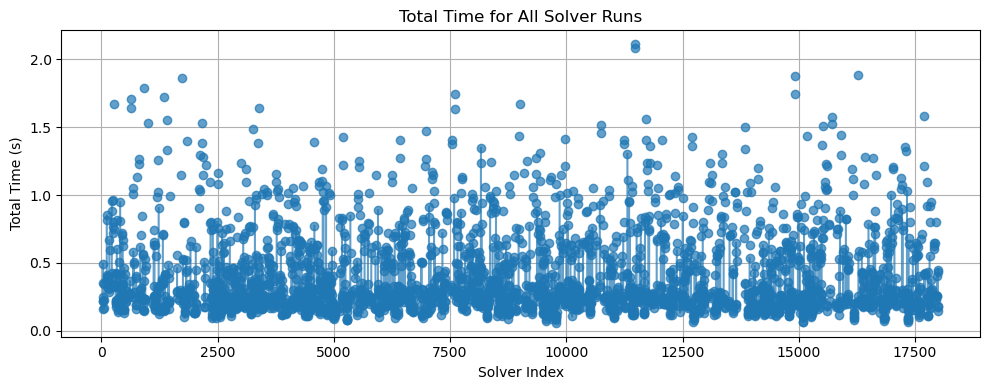

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(df["Total Time (s)"].values, marker='o', linestyle='-', alpha=0.7)
plt.xlabel("Solver Index")
plt.ylabel("Total Time (s)")
plt.title("Total Time for All Solver Runs")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
np.nanmax(df["Total Time (s)"].values)*2

4.221818447113037

## Create the MeshSolverDataset object

In [17]:
class MeshSolverDataset(Dataset):
    def __init__(self, mesh_dir, csv_path, transform=None, pre_transform=None, log_transform=True):
        """
        mesh_dir: directory with .msh files (e.g., 'D:/ML4pmg/Data/')
        csv_path: CSV file with solver results (e.g., 'D:/ML4pmg/Data/solver_times.csv')
        """
        super().__init__(mesh_dir, transform, pre_transform)
        self.mesh_dir = mesh_dir
        self.csv = pd.read_csv(csv_path)
        
        # Group by mesh ID to prepare target vectors per mesh
        self.mesh_targets = self.csv.pivot_table(
            index='Mesh #',
            columns='Solver Label',
            values='Adjusted Time (s)'
        ).sort_index()

        if log_transform:
            self.mesh_targets = self.mesh_targets.applymap(lambda x: -np.log(abs(x)))
        else:
            self.mesh_targets = self.mesh_targets.applymap(lambda x: (abs(x)))
        # List of available mesh IDs
        self.mesh_ids = self.mesh_targets.index.tolist()

        # Solver labels (for reference)
        self.solver_labels = self.mesh_targets.columns.tolist()

    def len(self):
        return len(self.mesh_ids)

    def get(self, idx):
        """
        Load mesh, convert to PyG Data object, and attach solver time vector as y
        """
        mesh_id = self.mesh_ids[idx]
        #mesh_filename = f"mesh2d_7fr_{mesh_id:03d}.msh"
        mesh_filename = f"mesh2d_Xfr_{mesh_id:04d}.msh"
        mesh_path = os.path.join(self.mesh_dir, mesh_filename)

        # Read mesh with meshio
        mesh = meshio.read(mesh_path)

        # Extract nodes (coordinates) and triangle elements
        coords = mesh.points.astype(np.float32)
        triangles = mesh.cells_dict.get("triangle")

        if triangles is None:
            raise ValueError(f"No triangle elements in {mesh_filename}")

        # PyG expects COO format edge_index: 2 x num_edges
        # For triangles, we make edges between each pair of triangle corners
        edge_index_list = []
        for tri in triangles:
            i, j, k = tri
            edge_index_list += [(i, j), (j, k), (k, i)]

        # Remove duplicates and convert to tensor
        edge_index = torch.tensor(list(set(edge_index_list)), dtype=torch.long).t().contiguous()

        # Features: here we use only coordinates as node features
        x = torch.tensor(coords, dtype=torch.float32)

        # Target: solver time vector for this mesh
        y_row = self.mesh_targets.loc[mesh_id].values.astype(np.float32)
        y = torch.tensor(y_row, dtype=torch.float32)

        # Build PyG data object
        data = Data(x=x, edge_index=edge_index, y=y)
        data.mesh_id = mesh_id  # optional: keep ID for reference
        return data


In [19]:
# dataset = MeshSolverDataset(
#     mesh_dir="D:/ML4pmg/Data/",
#     csv_path="D:/ML4pmg/Data/solver_times.csv",
#     log_transform=True
# )

dataset = MeshSolverDataset(
    mesh_dir="D:/ML4pmg/Data_Large2/",
    csv_path="D:/ML4pmg/Data_Large2/solver_times.csv",
    log_transform=True
)

print(f"Loaded {len(dataset)} graphs")
print(dataset[0])


Loaded 1000 graphs

Data(x=[9958, 3], edge_index=[2, 58971], y=[18], mesh_id=0)


In [20]:
data = dataset[0]
print(data.y) 


tensor([-1.4403, -1.4403, -1.4403, -1.4403, -1.4403, -1.4403, -1.4403, -1.4403,
        -1.4403, -1.4403, -1.4403, -1.4403, -1.4403, -1.4403, -1.4403, -1.4403,
        -1.4403, -1.4403])


## Visualize few samples in the dataset

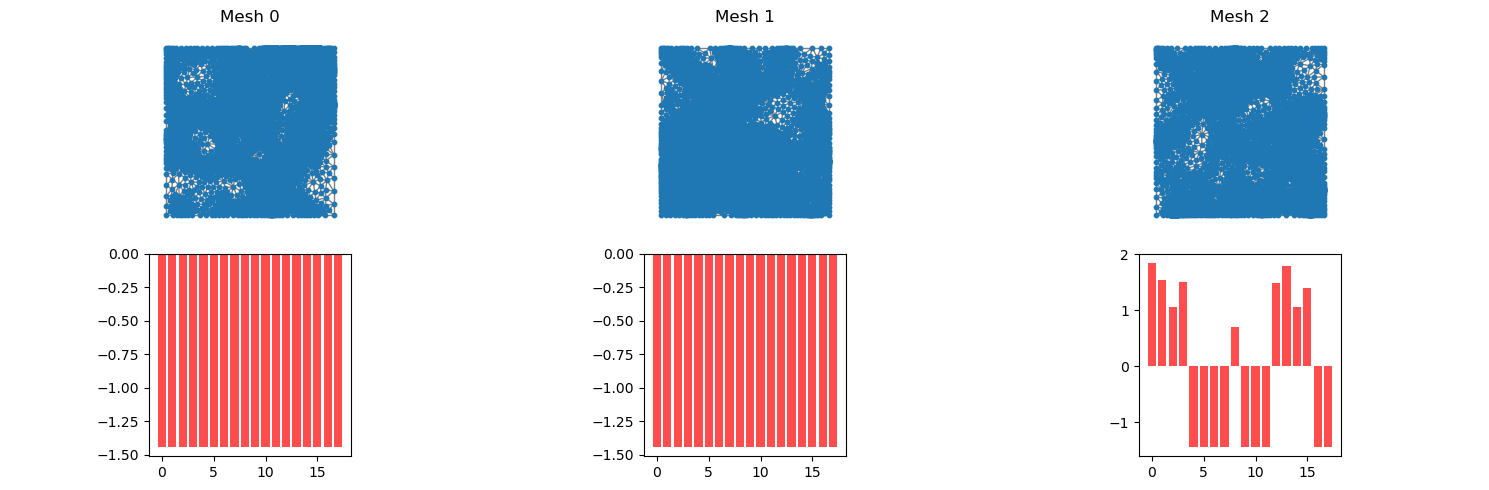

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

for i in range(3):
    data = dataset[i]
    G = to_networkx(data, to_undirected=True)
    
    # Use node coordinates for layout
    pos = {j: (data.x[j][0].item(), data.x[j][1].item()) for j in range(data.num_nodes)}
    
    ax = axes[0,i]
    nx.draw(
        G, pos=pos, ax=ax, node_size=10, edge_color="gray"
    )
    ax.set_title(f"Mesh {data.mesh_id}")
    ax.axis("equal")
    ax.axis("off")

    ax = axes[1,i]
    ax.bar(range(len(data.y)),data.y.numpy(), color='red', alpha=0.7)
    ax.set_box_aspect(1) 

plt.tight_layout()
plt.show()

## Balancing the data (in terms of convergence patterns)


Load the mesh_ids selected in DataPreprocessing, 50 meshes per pattern (9 top patterns)

Balanced dataset size will be of 450 meshes long


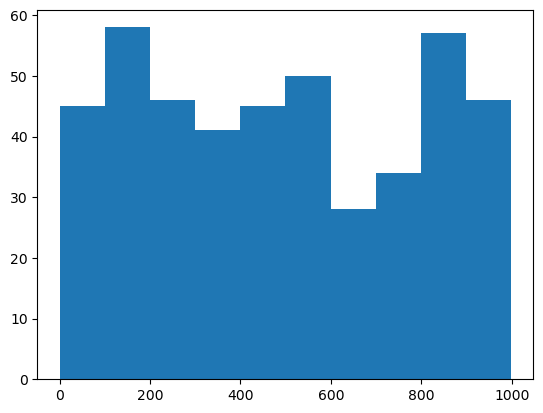

In [22]:
balanced_mesh_ids = np.loadtxt("Data_Large2/balanced_mesh_ids.csv", dtype=int).tolist()
print(f'Balanced dataset size will be of {len(balanced_mesh_ids)} meshes long')
plt.hist(balanced_mesh_ids, bins = 10);

In [23]:
class FilteredDataset(MeshSolverDataset):
    def __init__(self, mesh_dir, csv_path, selected_mesh_ids, **kwargs):
        super().__init__(mesh_dir, csv_path, **kwargs)

        # Override mesh_ids with the provided list (with duplicates)
        self.mesh_ids = selected_mesh_ids



allowed_ids = set(balanced_mesh_ids)
dataset = FilteredDataset(
    mesh_dir="D:/ML4pmg/Data_Large2/",
    csv_path="D:/ML4pmg/Data_Large2/solver_times.csv",
    selected_mesh_ids=balanced_mesh_ids,
    log_transform=True)
print(f"{len(dataset)} graphs loaded")

450 graphs loaded


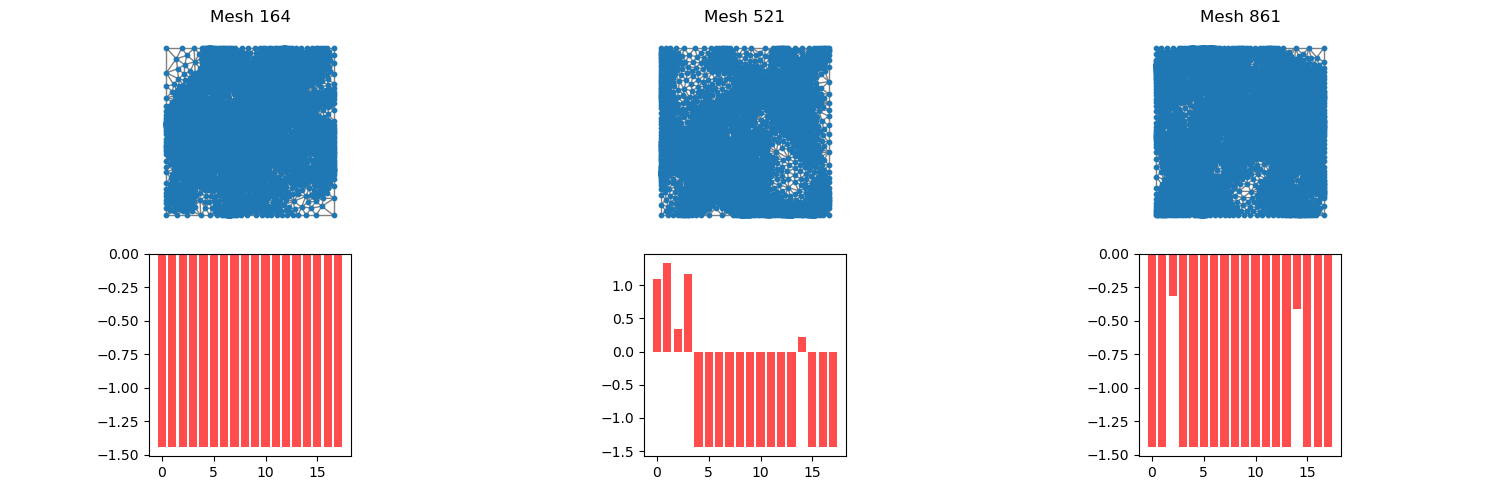

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

for i in range(3):
    data = dataset[i*50]
    G = to_networkx(data, to_undirected=True)
    
    # Use node coordinates for layout
    pos = {j: (data.x[j][0].item(), data.x[j][1].item()) for j in range(data.num_nodes)}
    
    ax = axes[0,i]
    nx.draw(
        G, pos=pos, ax=ax, node_size=10, edge_color="gray"
    )
    ax.set_title(f"Mesh {data.mesh_id}")
    ax.axis("equal")
    ax.axis("off")

    ax = axes[1,i]
    ax.bar(range(len(data.y)),data.y.numpy(), color='red', alpha=0.7)
    ax.set_box_aspect(1) 

plt.tight_layout()
plt.show()

## Create the model

Import needed packages

In [27]:
# For building the neural network
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool

# For data splitting and loading
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.utils.data import random_split


# For training
import torch.optim as optim

## First (Simple) Model

In [41]:
class MeshSolverTimeNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.output_dim = output_dim
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim,hidden_dim)
        #self.conv3 = GCNConv(hidden_dim,hidden_dim)
        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, output_dim)
        #self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x, edge_index, batch):
        # Graph convolutions
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        #x = self.conv3(x, edge_index)
        #x = F.relu(x)


        # Global pooling to get graph-level feature
        x = global_mean_pool(x, batch)

        # Fully connected layers
        x = self.lin1(x)
        x = F.relu(x)
        #x = self.dropout(x)
        x = self.lin2(x)  # Output: solver time vector
        #x = F.relu(x) # Possible make it positive
        return x


In [29]:
print("Node feature dim:", dataset[0].x.shape[1])
print("Target vector dim:", dataset[0].y.shape[0])



Node feature dim: 3

Target vector dim: 18


## Another model, based on reducing the graph

In [117]:
# For building the neural network
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool

class MeshSolverTimeNetPooled(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.output_dim = output_dim

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.pool1 = TopKPooling(hidden_dim, ratio=0.8)

        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.pool2 = TopKPooling(hidden_dim, ratio=0.5)

        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        # First conv + pooling
        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)

        # Second conv + pooling
        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)

        # Global pooling to get graph-level feature
        x = global_mean_pool(x, batch)

        # Fully connected layers
        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        return x



## Second (a bit more complex) Model

In [ ]:

class GATNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4):
        super(GATNet, self).__init__()
        self.output_dim = output_dim
        
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=0.0)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=0.0)
        self.conv3 = GATConv(hidden_dim, hidden_dim, heads=1, dropout=0.0)
        
        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=0.1)

    def forward(self, x, edge_index, batch):
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        
        x = global_mean_pool(x, batch)
        
        x = self.dropout(F.relu(self.lin1(x)))
        x = self.lin2(x)
        #x = F.relu(x)
        return x


In [ ]:
gnn_model = GATNet(
    input_dim=3,
    hidden_dim=64,
    output_dim=18
)

print(gnn_model)

num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

GATNet(
  (conv1): GATConv(3, 64, heads=4)
  (conv2): GATConv(256, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=21, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Number of trainable parameters: 27925


Split data and make dataset for single batch training

In [31]:
# Set random seed for reproducibility
torch.manual_seed(24)

# Define split sizes
total_len = len(dataset)
train_len = int(0.8 * total_len)
test_len = total_len - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len])


batch_size = None  # Set to None for full batch, or specify a number for mini-batches
if batch_size is None:
    # Merge all training graphs into one big batch
    
    with contextlib.redirect_stdout(None):
        train_batch = Batch.from_data_list([train_dataset[i] for i in range(len(train_dataset))]);
        test_batch = Batch.from_data_list([test_dataset[i] for i in range(len(test_dataset))]);
else:
    # Create loaders with mini-batches
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print(f"Train dataset: {len(train_dataset)} graphs")    
print(f"Test dataset: {len(test_dataset)} graphs")

Train dataset: 360 graphs
Test dataset: 90 graphs


In [32]:
for i in range(5):
    print(repr(train_dataset[i]))


Data(x=[7210, 3], edge_index=[2, 42759], y=[18], mesh_id=888)

Data(x=[7438, 3], edge_index=[2, 44235], y=[18], mesh_id=659)

Data(x=[7008, 3], edge_index=[2, 41211], y=[18], mesh_id=484)

Data(x=[5238, 3], edge_index=[2, 30786], y=[18], mesh_id=178)

Data(x=[5012, 3], edge_index=[2, 29466], y=[18], mesh_id=99)


In [120]:
# On whole dataset
def train_full_batch(model, batch, optimizer, criterion):
    m=model.output_dim
    model.train()
    optimizer.zero_grad()
    out = model(batch.x, batch.edge_index, batch.batch)
    loss = criterion(out, batch.y.view(-1, m))
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_full_batch(model, batch, criterion):
    m=model.output_dim
    model.eval()
    with torch.no_grad():
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1, m))

    return loss.item()

#Batch training and evaluation functions
def train_epoch(model, loader, optimizer, criterion):
    m=model.output_dim
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1, m))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs  # scale by batch size
    return total_loss / len(loader.dataset)


def evaluate_epoch(model, loader, criterion):
    m=model.output_dim
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y.view(-1, m))
            total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)


## Select and Initialize the model

In [ ]:
# gnn_model = MeshSolverTimeNet(
#     input_dim = 3,
#     hidden_dim = 64,
#     output_dim = 18
# )



gnn_model = MeshSolverTimeNetPooled(
    input_dim = 3,
    hidden_dim = 64,
    output_dim = 18
)

# gnn_model = GATNet(
#     input_dim=3,
#     hidden_dim=64,
#     output_dim=21
# )

print(gnn_model)

num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

In [121]:
data = dataset[0]
gnn_model.eval()  # set to evaluation mode
with torch.no_grad():
    batch_vector = torch.zeros(data.num_nodes, dtype=torch.long)  # all nodes belong to graph 0
    output = gnn_model(data.x, data.edge_index, batch_vector)
print("Output shape:", output.shape)  # should be (1, m)
print("Output:", output)


Output shape: torch.Size([1, 18])
Output: tensor([[ 0.0899, -0.0803, -0.0362, -0.0637, -0.0758, -0.1162, -0.0175, -0.0592,
          0.0951, -0.1100,  0.1000, -0.0306, -0.0766, -0.0883,  0.0231,  0.0049,
          0.0010,  0.0662]])


## Train the model

In [122]:
train_losses = []
test_losses = []

In [123]:
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [139]:
n_epochs = 10

if batch_size is not None:
    # Use mini-batch training
    for epoch in range(1, n_epochs + 1):
        t0=time.time()
        train_loss = train_epoch(gnn_model, train_loader, optimizer, criterion)
        test_loss = evaluate_epoch(gnn_model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        t1=time.time()
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Time Spent: {t1-t0:.2f}")
else:
    for epoch in range(1, n_epochs + 1):
        t0=time.time()
        with contextlib.redirect_stdout(None):
            train_loss = train_full_batch(gnn_model, train_batch, optimizer, criterion)
            test_loss = evaluate_full_batch(gnn_model, test_batch, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        t1=time.time()
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Time Spent: {t1-t0:.2f}")

Epoch 001 | Train Loss: 0.9001 | Test Loss: 0.8847 | Time Spent: 20.77
Epoch 002 | Train Loss: 0.9000 | Test Loss: 0.8874 | Time Spent: 20.64
Epoch 003 | Train Loss: 0.9045 | Test Loss: 0.8917 | Time Spent: 20.19
Epoch 004 | Train Loss: 0.9098 | Test Loss: 0.8940 | Time Spent: 20.34
Epoch 005 | Train Loss: 0.9120 | Test Loss: 0.8928 | Time Spent: 20.26
Epoch 006 | Train Loss: 0.9094 | Test Loss: 0.8893 | Time Spent: 20.41
Epoch 007 | Train Loss: 0.9035 | Test Loss: 0.8862 | Time Spent: 20.83
Epoch 008 | Train Loss: 0.8977 | Test Loss: 0.8851 | Time Spent: 21.60
Epoch 009 | Train Loss: 0.8940 | Test Loss: 0.8862 | Time Spent: 22.48
Epoch 010 | Train Loss: 0.8929 | Test Loss: 0.8883 | Time Spent: 22.89


In [140]:
print(f"Learning Rate = {optimizer.param_groups[0]['lr']:.6f}")

Learning Rate = 0.005000


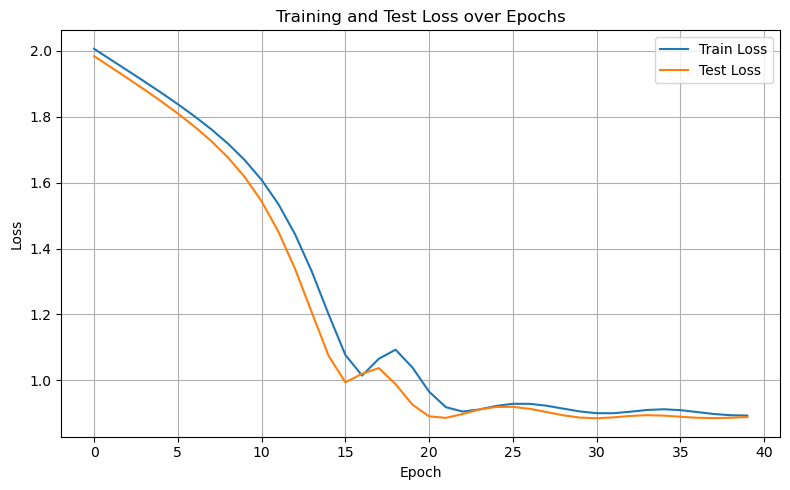

In [141]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Understand Predicitons

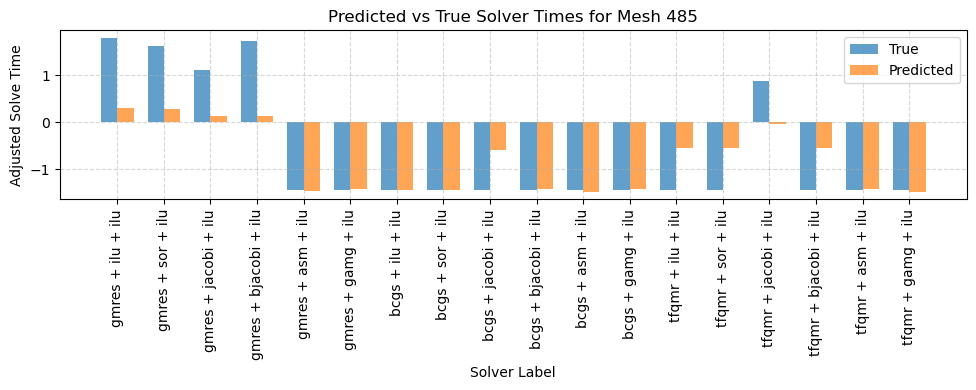

In [142]:
# Select one sample from test_dataset
data = test_dataset[0]

# Prepare batch vector (all zeros for a single graph)
batch_vector = torch.zeros(data.num_nodes, dtype=torch.long)

# Model to eval mode
gnn_model.eval()
with torch.no_grad():
    y_pred = gnn_model(data.x, data.edge_index, batch_vector).squeeze()
    y_true = data.y

# Convert to NumPy for plotting
y_pred = y_pred.numpy()
y_true = y_true.numpy()

# Plot
plt.figure(figsize=(10, 4))
width = 0.35
indices = range(len(y_true))

labels = df['Solver Label'].values[0:18]

plt.bar([i - width/2 for i in indices], y_true, width=width, label="True", alpha=0.7)
plt.bar([i + width/2 for i in indices], y_pred, width=width, label="Predicted", alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Solver Label")
plt.xticks(indices, labels, rotation=90)
plt.ylabel("Adjusted Solve Time")
plt.title(f"Predicted vs True Solver Times for Mesh {data.mesh_id}")
plt.legend()
plt.tight_layout()
plt.show()


In [143]:
indx_pred = np.argmin(np.exp(-y_pred))
indx_true = np.argmin(np.exp(-y_true))



print(f"Predicted solver: {labels[indx_pred]},   Total Time (s): {np.exp(-y_pred[indx_pred]):.5f} // vs {np.exp(-y_pred[indx_true]):.5f}")
print(f"True solver:      {labels[indx_true]},   Total Time (s): {np.exp(-y_true[indx_true]):.5f} // vs {np.exp(-y_true[indx_pred]):.5f}")
#print("---------------------------------------------------------------------------------")
#print(f"Predicted solver time for  {labels[indx_true]} is {np.exp(-y_pred[indx_true]):.5f}")
#print(f"True solver time for  {labels[indx_pred]} is {np.exp(-y_true[indx_pred]):.5f}")


Predicted solver: gmres + ilu + ilu,   Total Time (s): 0.74266 // vs 0.74266
True solver:      gmres + ilu + ilu,   Total Time (s): 0.16530 // vs 0.16530


In [132]:
print(y_true)
print(y_pred)


[ 1.8000069  1.6374495  1.115855   1.7349703 -1.4402659 -1.4402659
 -1.4402659 -1.4402659 -1.4402659 -1.4402659 -1.4402659 -1.4402659
 -1.4402659 -1.4402659  0.8797026 -1.4402659 -1.4402659 -1.4402659]
[ 0.28073674  0.49135825  0.22035648  0.74353194 -1.601349   -1.7137511
 -1.6371679  -1.6079426  -1.1476005  -1.7117671  -1.5662417  -1.6976836
 -1.3095475  -1.3228712  -0.05101817 -1.2736298  -1.6928856  -1.5231456 ]



Predicted solver: gmres + ilu + ilu,   Total Time (s): 0.74266 // vs 0.74266
True solver:      gmres + ilu + ilu,   Total Time (s): 0.16530 // vs 0.16530

Predicted solver: gmres + ilu + ilu,   Total Time (s): 0.75069 // vs 1.02351
True solver:      tfqmr + jacobi + ilu,   Total Time (s): 0.91152 // vs 4.22182

Predicted solver: gmres + ilu + ilu,   Total Time (s): 0.74787 // vs 0.87542
True solver:      gmres + jacobi + ilu,   Total Time (s): 0.98353 // vs 4.22182

Predicted solver: gmres + ilu + ilu,   Total Time (s): 0.74545 // vs 0.87179
True solver:      gmres + jacobi + ilu,   Total Time (s): 1.67143 // vs 4.22182


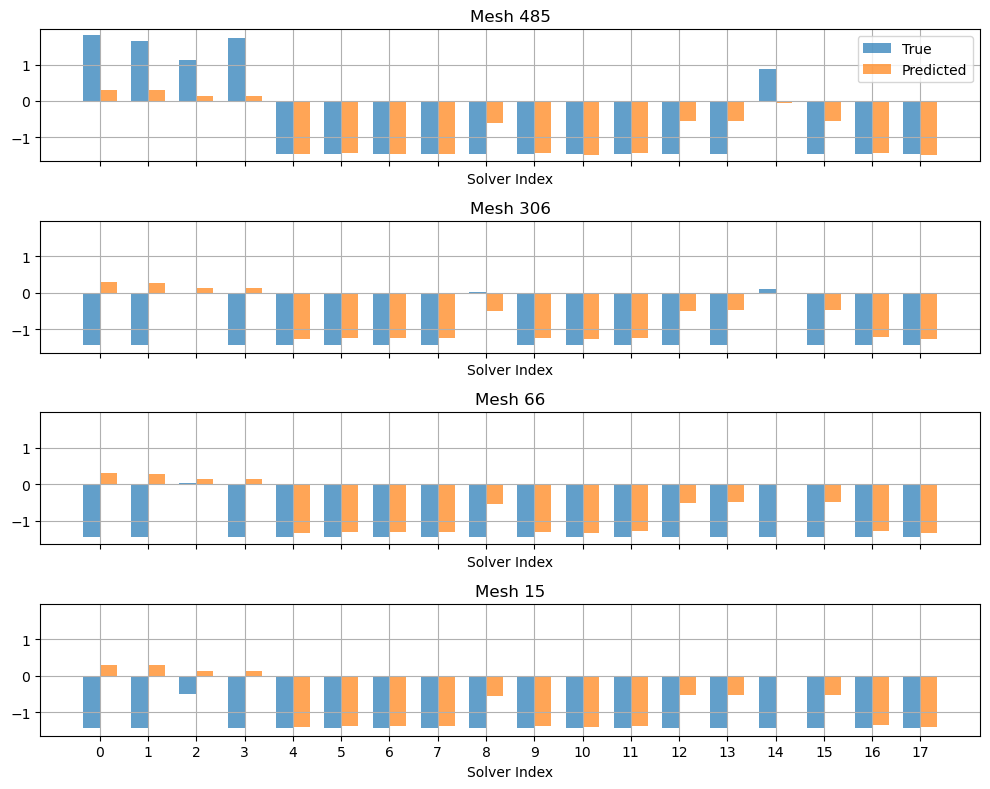

In [144]:
n = 4  # number of test samples to visualize

Y_pred, Y_true = [], []
fig, axes = plt.subplots(n, 1, figsize=(10, 2 * n),sharex=True, sharey=True)

gnn_model.eval()
with torch.no_grad():
    for i in range(n):
        j = i
        data = test_dataset[j]
        batch_vector = torch.zeros(data.num_nodes, dtype=torch.long)

        y_pred = gnn_model(data.x, data.edge_index, batch_vector).squeeze().numpy()
        y_true = data.y.numpy()
        
        Y_pred.append(y_pred)
        Y_true.append(y_true)

        ax = axes[i]
        width = 0.35
        indices = range(len(y_true))

        ax.bar([j - width/2 for j in indices], y_true, width=width, label="True", alpha=0.7)
        ax.bar([j + width/2 for j in indices], y_pred, width=width, label="Predicted", alpha=0.7)


        indx_pred = np.argmin(np.exp(-y_pred))
        indx_true = np.argmin(np.exp(-y_true))

        print(f"Predicted solver: {labels[indx_pred]},   Total Time (s): {np.exp(-y_pred[indx_pred]):.5f} // vs {np.exp(-y_pred[indx_true]):.5f}")
        print(f"True solver:      {labels[indx_true]},   Total Time (s): {np.exp(-y_true[indx_true]):.5f} // vs {np.exp(-y_true[indx_pred]):.5f}")

        ax.set_xlabel("Solver Index")
        ax.set_title(f"Mesh {data.mesh_id}")
        ax.set_xticks(indices)
        ax.grid(True)

    
    axes[0].legend()
    plt.tight_layout()
    plt.show()

### Accuracy for the training set:

In [598]:
# Forward pass
gnn_model.eval()
with torch.no_grad():
    y_pred = gnn_model(train_batch.x, train_batch.edge_index, train_batch.batch).numpy()
    y_true = train_batch.y.view(-1,21).numpy()

# Transform back from -log to positive time
y_pred_times = np.exp(-y_pred)
y_true_times = np.exp(-y_true)

pred_best = np.argmin(y_pred_times, axis=1)
true_best = np.argmin(y_true_times, axis=1)

matches = np.sum(pred_best == true_best)
total = len(pred_best)

print(f"Correct best solver prediction in {matches} out of {total} test cases, {100*matches/total: .2f} % accuracy.")

Correct best solver prediction in 190 out of 800 test cases,  23.75 % accuracy.


### Accuracy for the test set:


In [145]:
# Forward pass

m=gnn_model.output_dim
gnn_model.eval()
with torch.no_grad():
    y_pred = gnn_model(test_batch.x, test_batch.edge_index, test_batch.batch).numpy()
    y_true = test_batch.y.view(-1,m).numpy()

# Transform back from -log to positive time
y_pred_times = np.exp(-y_pred)
y_true_times = np.exp(-y_true)

pred_best = np.argmin(y_pred_times, axis=1)
true_best = np.argmin(y_true_times, axis=1)

aux = np.array(range(len(pred_best)))
dT_pp = y_pred_times[aux, pred_best] - y_pred_times[aux,true_best]
dT_tt = y_true_times[aux,pred_best] - y_true_times[aux,true_best]
dT_pt = y_pred_times[aux,pred_best] - y_true_times[aux,true_best]

matches = np.sum(pred_best == true_best)
total = len(pred_best)

print(f"Correct best solver prediction in {matches} out of {total} test cases,{100*matches/total: .2f} % accuracy.")

Correct best solver prediction in 25 out of 90 test cases, 27.78 % accuracy.


In [146]:
print(pred_best)
print(true_best)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 14  2  2  3  1  0  0  2  0  1 14  3  1  2  2 14  0  0  2  0  3  1  2
  1  3  1  3  0  0  2  0  2 14  0 14  1 14  3  1  1  0  1  0  3  3  0  0
  3  2  0  1  2  0  0  2  3  1  0  2  3  2  1  0  0  0  3  1  3  1  2  1
  1  0  2  2  0  1  3  1  0  2  1  2  0  2  1  3  3  2]


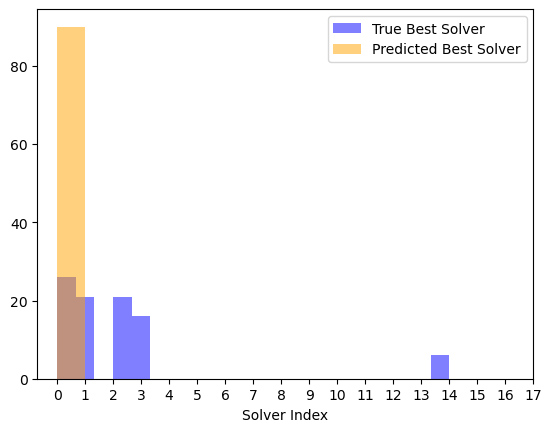

In [147]:
plt.hist(true_best, bins=21, alpha=0.5, label='True Best Solver', color='blue' );
plt.hist(pred_best, bins=1, alpha=0.5, label='Predicted Best Solver', color='orange');
plt.xlabel('Solver Index')
plt.xticks(indices);
plt.legend()
plt.show()  

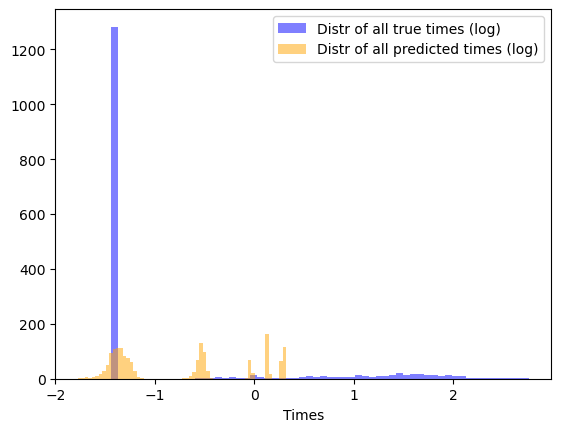

In [148]:
plt.hist(y_true.flatten(), bins=60, alpha=0.5, label='Distr of all true times (log)', color='blue' );
plt.hist(y_pred.flatten(), bins=60, alpha=0.5, label='Distr of all predicted times (log)', color='orange');
plt.xlabel('Times')
plt.legend()
plt.show()

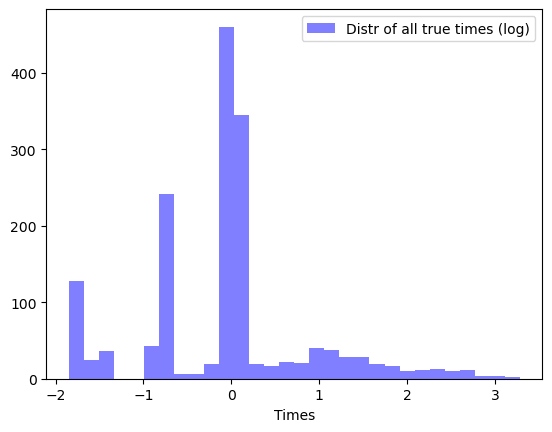

In [78]:
plt.hist(y_true.flatten() - y_pred.flatten(), bins=30, alpha=0.5, label='Distr of all true times (log)', color='blue' );
plt.xlabel('Times')
plt.legend()
plt.show()

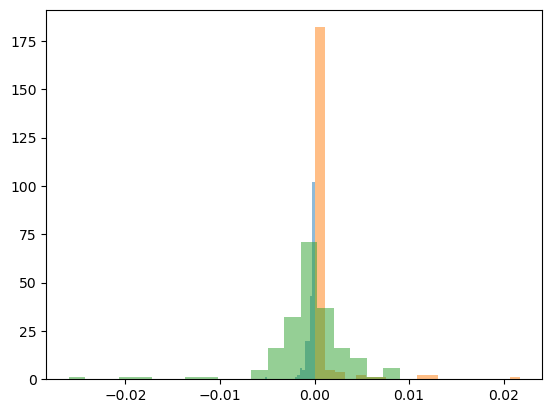

In [496]:
plt.hist(dT_pp, bins=20, alpha=0.5, label='Predicted - Predicted Best');
plt.hist(dT_tt, bins=20, alpha=0.5, label='True - True Best');
plt.hist(dT_pt, bins=20, alpha=0.5, label='True - Predicted Best');

Correct best solver prediction in 190 out of 800 test cases,  23.75 % accuracy.
